<img src="images/gradhats.jpg" align='center' alt="Students in cap and gown sitting at graduation" style="width: 800px;"/>

# Technical Overview
This project seeks to improve 6 year college graduation rates for black students in Illinois at Public Universities. Using regression modeling of financial [data](#Data-Understanding) from public four year colleges in US, the project found significant featues like increasing State grants and appropriations. a private university comparison will run throughout. [Modeling methods](#Methods) included Muliple Linear Regression using Lasso, Stepwise, and Random Forest Regression feature selection, along with GridSearchCV hyperparameter tuning (the best decision tree, random forest, k-nearest neighbor regression, and xgboost is available in the [appendix](#Appendix)). The [final model](#Evaluation) was a Multiple Linear Regression using the top 5 features from Stepwise and Lasso selection, with an R^2 value of .28 and a RMSE of 17.47, over a baseline of R^2 of 0 and RMSE of 20.68. [Implementation](#Recommendations) of this model predicts an increase in Illinois' black graduation rates. 

# Business Understanding
In [Public Act 102-0570](https://ilga.gov/legislation/publicacts/fulltext.asp?Name=102-0570), Illinois' General Assembly has commissioned the Illinois Board of Higher Education (IBHE) to offer "specific data-driven criteria and approaches to the General Assembly to adequately, equitably, and stably fund public universities in this State and to evaluate existing funding methods." This Commision on Equitable Public University Funding ([CEPUF](https://www.ibhe.org/Commission-on-Equitable-Public-University-Funding.html#:~:text=This%20Commission%20was%20created%20by,to%20evaluate%20existing%20funding%20methods.%E2%80%9D)) coincides with the [A Thriving Illinois: Higher Education Paths to Equity, Sustainability, and Growth](https://ibhestrategicplan.ibhe.org/IBHE-Strategic-Plan-2021.html) which includes providing "equitable funding so that students can receive the best educational experience and succeed at whichever institution they attend," and funding "institutions sufficiently to achieve student, institutional, and state goals."

This project targets 6-year black bachelors graduation rates for first-time, full-time students-- the typical measure for college student success-- using U.S. public and private university data from the Integrated Postsecondary Education Data System (IPEDS). This project aims to offer data-driven advice on how Illinois' universities might better leverage their financials towards black student success.

# Data Understanding
Data was accessed through [IPEDS](https://nces.ed.gov/ipeds/use-the-data/download-access-database). After downloading 10 years(2009-2020) of their Access database files (.accdb), [pyodbc module](https://pypi.org/project/pyodbc/) and SQL query were used to pull financial data (financial data (tables: DRVF, F_F1A, and F_F2) from 1681 public (587) and private (1094) universities (The IPEDS website does offer a [user-friendly query interface](https://nces.ed.gov/ipeds/datacenter/InstitutionList.aspx?goToReportId=1), but only 20 variables could be pulled at a time. The databases, private and public, were kept separate because of the differing financial categories (table and variables with F1 are from public Universities, while F2 is private not-for-profits-- f3 is private, for-profit, and was excluded from this project). Limitations with IPEDS data are discuss below.

### Imports

In [76]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pyodbc
import matplotlib.pyplot as plt

from functools import reduce

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.dummy import  DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor 

import warnings
warnings.filterwarnings("ignore")

### Retrieval and feature engineering
Here is an example of a query for the target variable for one of the 10 years of databases:
 
![code](images/retrieval.png)

After the queries were saved to csv, they were concatenated into two datafrrames: public and private. Notice, I created a 'year' column to see if any given year influenced overall graduation rates.  

![code](images/concatenate.png)

One advantage of IPEDS is that all tables have the same key: 'UNITID' (except for the provisional tables in 2019-2020 DRVC2019, DRVEF122019, DRVF2019, DRVIC2019, S2019_OC have key:'unitid'; S2019_IS and S2019_NH have key:'UnitiID'), which made joining a breeze. Here, now, are the completed dataframes:

In [77]:
df_private = pd.read_csv("data/private_financials_10.csv").iloc[:, 1:]
df_public = pd.read_csv("data/public_financials_10.csv").iloc[:, 1:]

### Labeling
A csv of school IDs and labels pulled from IPEDs for the index, and is merged to the dataframe. Labels for variables were also pulled from the table and variable documentation alongside the acces databases. Labels were transposed over variable names in excel.

In [78]:
#Read school id's
df_ids = pd.read_csv("data/university_ids.csv").iloc[:,0:2]
df_ids.rename(columns={'IPEDS\nUnit ID': 'UNITID', 'Organization or School Name':'School'}, inplace=True)
private_ids = [df_ids, df_private]
public_ids = [df_ids, df_public]
#Add school names
df_private= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), private_ids)
df_public= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), public_ids)
#Set Index
df_private.set_index(['School'], inplace=True)
df_public.set_index(['School'], inplace=True)

### Limitations
Because IPEDS is institutional in focus, it does not track specific cohorts of students; thus, financial information for individual students, including financial aid, loan default information, and family income are excluded. The target variable in particular only refers to full-time, first-time students, meaning transfers and part-time graduates are out. 

# Data Preparation
If the school did not have the target variable, it was excluded from the analysis. Sadly, Governors State University, a public school in Illinois, did not have any target information; therefore it was removed.School names and variable titles were merged and transposed for clarity. And columns with 40% data were dropped. Some of the financial metrics changed in 2014, so some columns are missin 40% of the data. These columns were the subcategories of Benefits, Operation and Maintenance of Plant, Depreciation, Interest, All Other for several categories. These categories post 2014 are now summarized in 'Total amount' and 'Salaries and wages' for Instruction, Research, Public service, etc. These subcategories and others missing 40% of data were dropped. 

In [79]:
#Drop schools if they do not have target
df_private = df_private[~df_private['Target'].isna()]
df_public = df_public[~df_public['Target'].isna()]

In [80]:
#drop 40% missing columns
num_pr= len(df_private) * .40
res = df_private.columns[df_private.isnull().sum() > num_pr]
df_private.drop(res, inplace=True, axis=1)

num_pub = len(df_public) * .40
res2 = df_public.columns[df_public.isnull().sum() > num_pub]
df_public.drop(res2, inplace=True, axis=1)

### EDA
Illinois schools need to be sliced from the public and private dataframes

In [81]:
#Slicing Illinois Private Schools
illinois_private = pd.read_csv("data/IL_private_schools.csv")
il_ids_pr=illinois_private["UnitID"].tolist()
illinois_pr = df_private[df_private["UNITID"].isin(il_ids_pr)]

In [82]:
#Slicing Illinois Public Schools
illinois_public = pd.read_csv("data/IL_public_schools.csv")
il_ids_pub=illinois_public["UnitID"].tolist()
illinois_pub = df_public[df_public["UNITID"].isin(il_ids_pub)]

#### Groupby school, year, and school and year for the Public and Private datasets, along with the subset of Illinois schools. 

In [83]:
#All private schools
private_schools= df_private.groupby("UNITID").mean()
private_byyear = df_private.groupby('Year').mean()
private_school_and_year = df_private.groupby(['UNITID', 'Year']).mean()
#All public schools
public_schools= df_public.groupby("UNITID").mean()
public_byyear = df_public.groupby('Year').mean()
public_school_and_year = df_public.groupby(['UNITID', 'Year']).mean()
# Illinois private schools
il_pr_schools= illinois_pr.groupby("UNITID").mean()
il_pr_byyear = illinois_pr.groupby('Year').mean()
il_pr_school_and_year = illinois_pr.groupby(['UNITID', 'Year']).mean()
#Illinois public schools
il_pub_schools= illinois_pub.groupby("UNITID").mean()
il_pub_byyear = illinois_pub.groupby('Year').mean()
il_pub_school_and_year = illinois_pub.groupby(['UNITID', 'Year']).mean()

### Illinois schools Black Graduation Rates
Illinois' public uniersities graduation rates vary from 8% at Northern Illinois University to 73% at University of Illinois. The illinois average is 37%. In comparison to the average of all college students in America graduating in 6 years is 60%. 


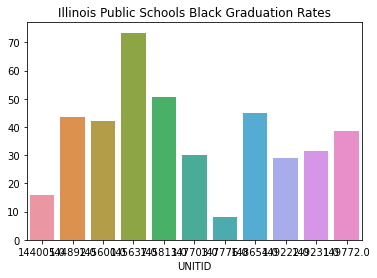

In [84]:
y =il_pub_schools['Target'].values
X = il_pub_schools['Target'].index
sns.barplot(X,y).set(title='Illinois Public Schools Black Graduation Rates');

### Black Graduation Rates over time
American public institutions of higher education are increasing black graduation rates, while Illinois is slightly decreasing.

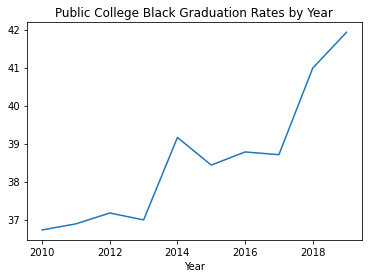

In [85]:
y =public_byyear['Target'].values
X = public_byyear['Target'].index
sns.lineplot(X,y).set(title='Public College Black Graduation Rates by Year');

But Illinois schools are trending in the opposite direction...

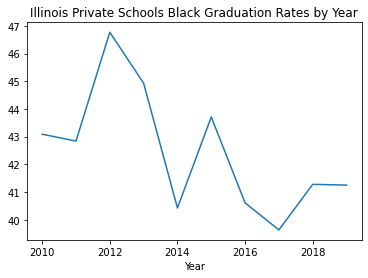

In [86]:
y =il_pr_byyear['Target'].values
X = il_pr_byyear['Target'].index
sns.lineplot(X,y).set(title='Illinois Private Schools Black Graduation Rates by Year');

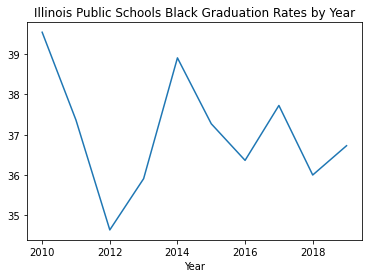

In [87]:
y =il_pub_byyear['Target'].values
X = il_pub_byyear['Target'].index
sns.lineplot(X,y).set(title='Illinois Public Schools Black Graduation Rates by Year');

### Train, Test, Split

In [88]:
#private
y_pr = df_private['Target']
X_pr = df_private.drop(columns = ['Target'], axis = 1)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr,
                                             y_pr, random_state = 42)
#and for public
y_pub = df_public['Target']
X_pub = df_public.drop(columns = ['Target'], axis = 1)
X_train_pub, X_test_pub, y_train_pub, y_test_pub = train_test_split(X_pub, 
                                            y_pub, random_state = 42)


# Methods
Because the Illinois Board of Higher Education is seeking specific policy advice, this project will avoid black-box and hard-to-interpret models. The approach is simple: starting with a baseline, iterate through Linear Regressions to find the best model. Different Selection types, like Stepwise(to only pull statistically significant features), Lasso (to penalize weak features), Random Forest Regression are used A Pipeline to preprocess imputing and standardizing was also used to speed up the process.Data was normalized at point of regression, to make it more readable for the model. 

### Pipeline
Ramaining missing values will be imputed. And due to the high variance between financial variables, they will be standardized. 

In [89]:
pipeline = Pipeline(steps=[
    ('si', SimpleImputer()),
    ('ss', StandardScaler())
])

### Baseline
A simple dummy regressor that guesses the mean. The basic structure below will be kept for all models: fit, predictions, score, cross-validate, and rmse. 

In [90]:
dummy_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
#Fit model
dummy_pr.fit(X_train_pr, y_train_pr)

#Grab predictions
dummy_pr_preds= dummy_pr.predict(X_train_pr)

#R^2 score
dummy_pr_score = dummy_pr.score(X_train_pr, y_train_pr)
print("Dummy PR R^2 Training Score:" + str(dummy_pr_score))

#Run a cross validation to test for overfitting
dummy_pr_v= np.mean(cross_val_score(dummy_pr, X_train_pr, y_train_pr, cv=5))
print("Dummy PR R^2 Validation Score:" + str(dummy_pr_v))

#RMSE
dummy_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,dummy_pr_preds))
print('Dummy PR Root Mean Squared Error:' + str(dummy_pr_rmse))

Dummy PR R^2 Training Score:0.0
Dummy PR R^2 Validation Score:-0.0005092556664282544
Dummy PR Root Mean Squared Error:26.991139559568747


In [91]:
#Public
dummy_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
dummy_pub.fit(X_train_pub, y_train_pub)
dummy_pub_preds =dummy_pub.predict(X_train_pub)
dummy_pub_score = dummy_pub.score(X_train_pub, y_train_pub)
print("Dummy PUB R^2 Training Score:" + str(dummy_pub_score))
dummy_pub_v= np.mean(cross_val_score(dummy_pr, X_train_pub, y_train_pub, cv=5))
print("Dummy PUB R^2 Validation Score:" + str(dummy_pub_v))
dummy_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,dummy_pub_preds))
print('Dummy PUB Root Mean Squared Error:' +str(dummy_pub_rmse))

Dummy PUB R^2 Training Score:0.0
Dummy PUB R^2 Validation Score:-0.000665679256072016
Dummy PUB Root Mean Squared Error:20.67988980644399


### Multiple Linear Regression
First Simple Model is a Linear Regession, normalized. 

In [92]:
#Private
lr_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('ols', LinearRegression(normalize=True))
])
lr_pr.fit(X_train_pr, y_train_pr)
y_pred_lr_pr = lr_pr.predict(X_train_pr)
lr_pr_score=lr_pr.score(X_train_pr, y_train_pr)
print("LR PR R^2 Training Score:" + str(lr_pr_score))
lr_pr_v=scores_pr= np.mean(cross_val_score(lr_pr, X_train_pr, y_train_pr, cv=5))
print("LR PR R^2 Validation Score:" + str(lr_pr_v))
lr_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr))
print('LR PR Root Mean Squared Error:' +str(lr_pr_rmse))

LR PR R^2 Training Score:0.40696492429304176
LR PR R^2 Validation Score:-3.170656294840613e+29
LR PR Root Mean Squared Error:20.78554475932907


In [93]:
#for public
lr_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('ols', LinearRegression(normalize=True))
])
lr_pub.fit(X_train_pub, y_train_pub)
y_pred_lr_pub = lr_pub.predict(X_train_pub)
lr_pub_score= lr_pub.score(X_train_pub, y_train_pub)
print("LR PUB R^2 Score:" + str(lr_pub_score))
lr_pub_v = np.mean(cross_val_score(lr_pub, X_train_pub, y_train_pub, cv=5))
print("LR PUB R^2 Validation Score:" + str(lr_pub_v))
lr_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_lr_pub))
print('LR PUB Root Mean Squared Error:' + str(lr_pub_rmse))

LR PUB R^2 Score:0.3980977047126869
LR PUB R^2 Validation Score:-2046505981563278.5
LR PUB Root Mean Squared Error:16.04394704996848


### MLR with Random Forest Selection
That model did better than baseline, but was definitely overfit as evidenced by the cross-validation numbers. This time, after optimizing the forest with gridsearched, the MLR uses random forest regressor for feature selection.

In [94]:
#Private
lr_pr_forest = Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))),
    ('ols', LinearRegression(normalize=True))
])
lr_pr_forest.fit(X_train_pr, y_train_pr)
y_pred_lr_pr_forest = lr_pr_forest.predict(X_train_pr)
lr_pr_forest_score=lr_pr_forest.score(X_train_pr, y_train_pr)
print("LR Forest PR R^2 Training Score:" + str(lr_pr_forest_score))
lr_pr_forest_v=scores_pr= np.mean(cross_val_score(lr_pr_forest, X_train_pr, y_train_pr, cv=5))
print("LR Forest PR R^2 Validation Score:" + str(lr_pr_forest_v))
lr_pr_forest_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr_forest))
print('LR Forest PR Root Mean Squared Error:' +str(lr_pr_forest_rmse))

LR Forest PR R^2 Training Score:0.2959322245152466
LR Forest PR R^2 Validation Score:0.24492642759969754
LR Forest PR Root Mean Squared Error:22.647926895664636


In [95]:
#for public
lr_pub_forest = Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6))),
    ('ols', LinearRegression(normalize=True))
])
lr_pub_forest.fit(X_train_pub, y_train_pub)
y_pred_lr_pub_forest = lr_pub_forest.predict(X_train_pub)
lr_pub_forest_score= lr_pub_forest.score(X_train_pub, y_train_pub)
print("LR PUB Forest R^2 Score:" + str(lr_pub_forest_score))
lr_pub_forest_v = np.mean(cross_val_score(lr_pub_forest, X_train_pub, y_train_pub, cv=5))
print("LR PUB Forest R^2 Validation Score:" + str(lr_pub_forest_v))
lr_pub_forest_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_lr_pub))
print('LR PUB Forest Root Mean Squared Error:' + str(lr_pub_forest_rmse))

LR PUB Forest R^2 Score:0.33234451017123423
LR PUB Forest R^2 Validation Score:0.32299540289245854
LR PUB Forest Root Mean Squared Error:16.04394704996848


### Stepwise Feature Selection
The previous model did much better, actually underfitting this time. The RMSE remains close to 16. So, in hopes of reducing multicollinearity and improving model performance, stepwise feature selection was used. Stepwise adds significant features, but removes them if they do not remain significant after joining other variables. 

In [96]:
#Impute outside of the pipeline
si= SimpleImputer()
X_train_pr_imputed= si.fit_transform(X_train_pr)
X_train_pub_imputed= si.fit_transform(X_train_pub)
X_train_pr_imputed=pd.DataFrame(X_train_pr_imputed, 
    index=X_train_pr.index, columns=X_train_pr.columns)
X_train_pub_imputed=pd.DataFrame(X_train_pub_imputed, 
    index=X_train_pub.index, columns=X_train_pub.columns)

In [97]:
import statsmodels.api as sm
			
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            #if verbose:
                #print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(included[worst_feature])
            #if verbose:
                #print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    included.append('id')
    print('resulting features:')
    print(included)
    
    return included

In [98]:
stepwise_selection(X_train_pr_imputed, y_train_pr)


resulting features:
['Revenues from tuition and fees per FTE (FASB)', 'Endowment assets (year end) per FTE enrollment (FASB)', 'Investment return as a percent of core revenues (FASB)', 'Core revenues, total dollars (FASB)', 'Instruction expenses per FTE  (FASB)', 'Allowances applied to tuition and fees', 'Year', 'Instruction-Salaries and wages', 'Equity ratio (FASB)', 'Contributions from affiliated entities - Total', 'Sales and services of educational activities - Unrestricted', 'Sales and services of educational activities - Total', 'Sales and services of auxiliary enterprises - Unrestricted', 'Sales and services of auxiliary enterprises - Total', 'Institutional support expenses as a percent of total core expenses (FASB)', 'Pell grants', 'Student service-Salaries and wages', 'Auxiliary enterprises-Salaries and wages', 'Accumulated depreciation', 'Total Plant, Property, and Equipment', 'Property, Plant, and Equipment, net of accumulated depreciation ', 'Tuition and fees - Permanently r

['Revenues from tuition and fees per FTE (FASB)',
 'Endowment assets (year end) per FTE enrollment (FASB)',
 'Investment return as a percent of core revenues (FASB)',
 'Core revenues, total dollars (FASB)',
 'Instruction expenses per FTE  (FASB)',
 'Allowances applied to tuition and fees',
 'Year',
 'Instruction-Salaries and wages',
 'Equity ratio (FASB)',
 'Contributions from affiliated entities - Total',
 'Sales and services of educational activities - Unrestricted',
 'Sales and services of educational activities - Total',
 'Sales and services of auxiliary enterprises - Unrestricted',
 'Sales and services of auxiliary enterprises - Total',
 'Institutional support expenses as a percent of total core expenses (FASB)',
 'Pell grants',
 'Student service-Salaries and wages',
 'Auxiliary enterprises-Salaries and wages',
 'Accumulated depreciation',
 'Total Plant, Property, and Equipment',
 'Property, Plant, and Equipment, net of accumulated depreciation ',
 'Tuition and fees - Permanently 

In [99]:
stepwise_selection(X_train_pub_imputed, y_train_pub)

resulting features:
['Institutional support - Salaries and wages', 'Instruction expenses per FTE  (GASB)', 'Sales and services of auxiliary enterprises', 'Discounts and allowances applied to sales & services of auxiliary enterprises', 'Government grants and contracts as a percent of core revenues (GASB)', 'Grants by state government', 'Does this institution or any of its foundations or other affiliated organizations own endowment assets ?', 'Student service expenses per FTE (GASB)', 'Research expenses as a percent of total core expenses (GASB)', 'Other nonoperating revenues  ', 'Equity ratio (GASB)', 'Revenues from state appropriations per FTE (GASB)', 'Restricted-nonexpendable', 'Auxiliary enterprises -- Salaries and wages', 'Institutional support expenses per FTE (GASB)', 'Academic support expenses as a percent of total core expenses (GASB)', 'Local nonoperating grants', 'Total current liabilities', 'Revenues from local appropriations per FTE (GASB)', 'Unnamed: 213', 'Institutional g

['Institutional support - Salaries and wages',
 'Instruction expenses per FTE  (GASB)',
 'Sales and services of auxiliary enterprises',
 'Discounts and allowances applied to sales & services of auxiliary enterprises',
 'Government grants and contracts as a percent of core revenues (GASB)',
 'Grants by state government',
 'Does this institution or any of its foundations or other affiliated organizations own endowment assets ?',
 'Student service expenses per FTE (GASB)',
 'Research expenses as a percent of total core expenses (GASB)',
 'Other nonoperating revenues  ',
 'Equity ratio (GASB)',
 'Revenues from state appropriations per FTE (GASB)',
 'Restricted-nonexpendable',
 'Auxiliary enterprises -- Salaries and wages',
 'Institutional support expenses per FTE (GASB)',
 'Academic support expenses as a percent of total core expenses (GASB)',
 'Local nonoperating grants',
 'Total current liabilities',
 'Revenues from local appropriations per FTE (GASB)',
 'Unnamed: 213',
 'Institutional g

#### Reduce X_train's to selectwise columns
35 Private and 37 Public variables were selected and will be sliced from the respective dataframes.

In [100]:
X_train_pr_sw=X_train_pr_imputed[['Revenues from tuition and fees per FTE (FASB)',
 'Endowment assets (year end) per FTE enrollment (FASB)',
'Investment return as a percent of core revenues (FASB)',
'Core revenues, total dollars (FASB)',
'Instruction expenses per FTE  (FASB)', 
'Allowances applied to tuition and fees',
'Year', 'Instruction-Salaries and wages', 
'Equity ratio (FASB)', 
'Contributions from affiliated entities - Total', 
'Sales and services of educational activities - Total',
'Sales and services of educational activities - Unrestricted', 
'Sales and services of auxiliary enterprises - Total',
'Sales and services of auxiliary enterprises - Unrestricted',
'Institutional support expenses as a percent of total core expenses (FASB)', 
'Pell grants', 'Student service-Salaries and wages', 
'Auxiliary enterprises-Salaries and wages', 
'Accumulated depreciation', 
'Total Plant, Property, and Equipment', 
'Property, Plant, and Equipment, net of accumulated depreciation ', 
'Tuition and fees - Permanently restricted', 
'Net grant aid to students-Total amount', 
'Permanently restricted net assets included in total restricted net assets', 
'Student service expenses as a percent of total core expenses (FASB)', 
'Revenues from private gifts, grants, contracts/contributions from affiliated entities per FTE (FASB)', 
'Student service expenses per FTE (FASB)', 
'Intangible Assets, net of accumulated amortization', 
'Institutional support-Salaries and wages', 
'Government grants and contracts as a percent of core revenues (FASB)', 
'Federal grants and contracts  - Temporarily restricted', 
'Revenues from investment return per FTE (FASB)', 
'Investment return - Total', 
'Value of endowment assets at the end of the fiscal year', 
'Value of endowment assets at the beginning of the fiscal year  ']]

In [101]:
X_train_pub_sw=X_train_pub_imputed[['Institutional support - Salaries and wages', 
'Instruction expenses per FTE  (GASB)', 
'Sales and services of auxiliary enterprises', 
'Discounts and allowances applied to sales & services of auxiliary enterprises', 
'Government grants and contracts as a percent of core revenues (GASB)', 
'Grants by state government', 
'Does this institution or any of its foundations or other affiliated organizations own endowment assets ?', 
'Student service expenses per FTE (GASB)', 
'Research expenses as a percent of total core expenses (GASB)', 
'Other nonoperating revenues  ', 
'Equity ratio (GASB)', 
'Revenues from state appropriations per FTE (GASB)', 
'Restricted-nonexpendable', 
'Auxiliary enterprises -- Salaries and wages', 
'Institutional support expenses per FTE (GASB)', 
'Academic support expenses as a percent of total core expenses (GASB)', 
'Local nonoperating grants', 
'Total current liabilities', 
'Revenues from local appropriations per FTE (GASB)', 
'Unnamed: 213', 
'Institutional grants from unrestricted resources ', 
'Instruction - Current year total', 
'Academic support expenses per FTE (GASB)', 
'Depreciable capital assets, net of depreciation ', 
'Public service expenses as a percent of total core expenses (GASB)', 
'Year', 'Other expenses  deductions - Current year total', 
'Local/private operating grants and contracts', 
'Other noncurrent liabilities ', 
'Additions to permanent endowments', 
'Tuition and fees, after deducting discounts and allowances', 
'Revenues from tuition and fees per FTE (GASB)', 
'Federal appropriations', 
'Revenues from government grants and contracts per FTE (GASB)', 
'Research expenses per FTE  (GASB)', 
'Private gifts, grants, and contracts as a percent of core revenues (GASB)', 
'State appropriations as percent of core revenues  (GASB)']]

### MLR with Lasso
Using the new stepwise selected variables, another MLR will add an L1 penalty for further selection help. 

In [102]:
#Private
lr_pr_sw = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pr_sw.fit(X_train_pr_sw, y_train_pr)
y_pred_lr_pr_sw = lr_pr_sw.predict(X_train_pr_sw)
lr_pr_sw_score=lr_pr_sw.score(X_train_pr_sw, y_train_pr)
print("LR PR SW R^2 Training Score:" + str(lr_pr_sw_score))
lr_pr_sw_v=scores_pr= np.mean(cross_val_score(lr_pr_sw, X_train_pr_sw, y_train_pr, cv=5))
print("LR PR SW R^2 Validation Score:" + str(lr_pr_sw_v))
lr_pr_sw_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr_sw))
print('LR PR SW Root Mean Squared Error:' +str(lr_pr_sw_rmse))

LR PR SW R^2 Training Score:0.3606632176164071
LR PR SW R^2 Validation Score:0.3567282760080489
LR PR SW Root Mean Squared Error:21.581720623124944


In [103]:
#for public
lr_pub_sw = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pub_sw.fit(X_train_pub_sw, y_train_pub)
y_pred_lr_pub_sw = lr_pub_sw.predict(X_train_pub_sw)
lr_pub_sw_score= lr_pub_sw.score(X_train_pub_sw, y_train_pub)
print("LR PUB SW R^2 Score:" + str(lr_pub_sw_score))
lr_pub_sw_v = np.mean(cross_val_score(lr_pub_sw, X_train_pub_sw, y_train_pub, cv=5))
print("LR PUB SW R^2 Validation Score:" + str(lr_pub_sw_v))
lr_pub_sw_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_lr_pub_sw))
print('LR PUB SW Root Mean Squared Error:' + str(lr_pub_sw_rmse))

LR PUB SW R^2 Score:0.37465936565301516
LR PUB SW R^2 Validation Score:0.36397347502062644
LR PUB SW Root Mean Squared Error:16.353342974879705


In [104]:
#Feature Importance
important_private = []
for name, coef in zip(X_train_pr_sw.columns, lr_pr_sw['ols'].coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True))

[('Allowances applied to tuition and fees', 6.98824759861806), ('Revenues from tuition and fees per FTE (FASB)', 5.992440439633291), ('Sales and services of auxiliary enterprises - Total', 3.610134982505885), ('Instruction expenses per FTE  (FASB)', 2.6658820800638665), ('Endowment assets (year end) per FTE enrollment (FASB)', 2.6303845622359376), ('Investment return as a percent of core revenues (FASB)', 2.3008899647159677), ('Equity ratio (FASB)', 2.2866096032013825), ('Instruction-Salaries and wages', 1.320309869596752), ('Sales and services of educational activities - Total', -1.0838110931989504), ('Year', -1.6919513984697738), ('Contributions from affiliated entities - Total', -1.8955958792389707), ('Sales and services of educational activities - Unrestricted', -3.0530014525654927), ('Core revenues, total dollars (FASB)', -6.742601887358351)]


In [105]:
#Feature Importance for public
important_public = []
for name, coef in zip(X_train_pub_sw.columns, lr_pub_sw['ols'].coef_):
    important_public.append((name, coef))
print(sorted(important_public, key=lambda tup: tup[1], reverse=True))

[('Discounts and allowances applied to sales & services of auxiliary enterprises', 3.489351536080421), ('Sales and services of auxiliary enterprises', 2.904080790824559), ('Grants by state government', 2.5197045909859517), ('Research expenses as a percent of total core expenses (GASB)', 2.4324728130197677), ('Revenues from state appropriations per FTE (GASB)', 2.4201441653904214), ('Institutional support expenses per FTE (GASB)', 1.8646054306453301), ('Auxiliary enterprises -- Salaries and wages', 1.7118862896303477), ('Student service expenses per FTE (GASB)', 1.6602505708199415), ('Equity ratio (GASB)', 1.434582253444649), ('Instruction expenses per FTE  (GASB)', 0.4187106419300782), ('Institutional support - Salaries and wages', 0.24153814397117593), ('Other nonoperating revenues  ', -1.5861956682276537), ('Restricted-nonexpendable', -1.7939605004028387), ('Government grants and contracts as a percent of core revenues (GASB)', -2.1482493537660754), ('Does this institution or any of 

# Evaluation


#### Comparing all Models
For both Private and Public models, the best model was the stepwise with lasso mulitple linear regression. R^2 was chosen to see how much of the variance can be explained by the model. The Root Mean Squared Error tries to reduce the mistakes the model will make in prediction, giving a better sense whether the feature will actually influence black graduations or not. 

In [106]:

print("Dummy PR R^2 Training Score:" + str(dummy_pr_score))
print("Dummy PR R^2 Validation Score:" + str(dummy_pr_v))
print('Dummy PR Root Mean Squared Error:' + str(dummy_pr_rmse))
print('')
print("LR PR R^2 Training Score:" + str(lr_pr_score))
print("LR PR R^2 Validation Score:" + str(lr_pr_v))
print('LR PR Root Mean Squared Error:' +str(lr_pr_rmse))
print('')
print("LR Forest PR R^2 Training Score:" + str(lr_pr_forest_score))
print("LR Forest PR R^2 Validation Score:" + str(lr_pr_forest_v))
print('LR Forest PR Root Mean Squared Error:' +str(lr_pr_forest_rmse))
print('')
print("LR PR SW R^2 Training Score:" + str(lr_pr_sw_score))
print("LR PR SW R^2 Validation Score:" + str(lr_pr_sw_v))
print('LR PR SW Root Mean Squared Error:' +str(lr_pr_sw_rmse))

Dummy PR R^2 Training Score:0.0
Dummy PR R^2 Validation Score:-0.0005092556664282544
Dummy PR Root Mean Squared Error:26.991139559568747

LR PR R^2 Training Score:0.40696492429304176
LR PR R^2 Validation Score:-3.170656294840613e+29
LR PR Root Mean Squared Error:20.78554475932907

LR Forest PR R^2 Training Score:0.2959322245152466
LR Forest PR R^2 Validation Score:0.24492642759969754
LR Forest PR Root Mean Squared Error:22.647926895664636

LR PR SW R^2 Training Score:0.3606632176164071
LR PR SW R^2 Validation Score:0.3567282760080489
LR PR SW Root Mean Squared Error:21.581720623124944


In [107]:
print("Dummy PUB R^2 Training Score:" + str(dummy_pub_score))
print("Dummy PUB R^2 Validation Score:" + str(dummy_pub_v))
print('Dummy PUB Root Mean Squared Error:' +str(dummy_pub_rmse))
print('')
print("LR PUB R^2 Score:" + str(lr_pub_score))
print("LR PUB R^2 Validation Score:" + str(lr_pub_v))
print('LR PUB Root Mean Squared Error:' + str(lr_pub_rmse))
print('')
print("LR PUB Forest R^2 Score:" + str(lr_pub_forest_score))
print("LR PUB Forest R^2 Validation Score:" + str(lr_pub_forest_v))
print('LR PUB Forest Root Mean Squared Error:' + str(lr_pub_forest_rmse))
print('')
print("LR PUB SW R^2 Score:" + str(lr_pub_sw_score))
print("LR PUB SW R^2 Validation Score:" + str(lr_pub_sw_v))
print('LR PUB SW Root Mean Squared Error:' + str(lr_pub_sw_rmse))

Dummy PUB R^2 Training Score:0.0
Dummy PUB R^2 Validation Score:-0.000665679256072016
Dummy PUB Root Mean Squared Error:20.67988980644399

LR PUB R^2 Score:0.3980977047126869
LR PUB R^2 Validation Score:-2046505981563278.5
LR PUB Root Mean Squared Error:16.04394704996848

LR PUB Forest R^2 Score:0.33234451017123423
LR PUB Forest R^2 Validation Score:0.32299540289245854
LR PUB Forest Root Mean Squared Error:16.04394704996848

LR PUB SW R^2 Score:0.37465936565301516
LR PUB SW R^2 Validation Score:0.36397347502062644
LR PUB SW Root Mean Squared Error:16.353342974879705


### Unscaled MLR with top 5 features
The final model is the best model: Multiple Linear Regression with Stepwise and Lasso selection, with an R^2 schore of .36 and a RMSE of 16.35. Because the project demands specific policy recommendations, predictive power will be sacrificed for interpretability. Thus, the model will be unscaled, and only the top five features based on the absolute value of their coefficients will be selected.

In [108]:
#pull top 5 impactful features
X_train_pr_unscaled= X_train_pr_sw[['Allowances applied to tuition and fees', 
'Revenues from tuition and fees per FTE (FASB)', 
'Sales and services of auxiliary enterprises - Total',
'Sales and services of educational activities - Unrestricted', 
'Core revenues, total dollars (FASB)']]

X_train_pub_unscaled= X_train_pub_sw[['Discounts and allowances applied to sales & services of auxiliary enterprises',
'Sales and services of auxiliary enterprises',
'Grants by state government', 
'Research expenses as a percent of total core expenses (GASB)', 
'Revenues from state appropriations per FTE (GASB)']]


In [109]:
final_lr_pr=LinearRegression()
final_lr_pr.fit(X_train_pr_unscaled, y_train_pr)
y_pred_final_lr_pr = final_lr_pr.predict(X_train_pr_unscaled)
final_lr_pr_score= final_lr_pr.score(X_train_pr_unscaled, y_train_pr)
print("Final LR PR R^2 Score:" + str(final_lr_pr_score))
final_lr_pr_v = np.mean(cross_val_score(final_lr_pr, X_train_pr_unscaled, y_train_pr, cv=5))
print("Final LR PR R^2 Validation Score:" + str(final_lr_pr_v))
final_lr_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_final_lr_pr))
print('Final LR PR Root Mean Squared Error:' + str(final_lr_pr_rmse))

Final LR PR R^2 Score:0.26973678558827285
Final LR PR R^2 Validation Score:0.26771823206893564
Final LR PR Root Mean Squared Error:23.06539694297186


In [110]:
final_lr_pub=LinearRegression()
final_lr_pub.fit(X_train_pub_unscaled, y_train_pub)
y_pred_final_lr_pub = final_lr_pub.predict(X_train_pub_unscaled)
final_lr_pub_score= final_lr_pub.score(X_train_pub_unscaled, y_train_pub)
print("Final LR PUB R^2 Score:" + str(final_lr_pub_score))
final_lr_pub_v = np.mean(cross_val_score(final_lr_pub, X_train_pub_unscaled, y_train_pub, cv=5))
print("Final LR PUB R^2 Validation Score:" + str(final_lr_pub_v))
final_lr_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_final_lr_pub))
print('Final LR PUB Root Mean Squared Error:' + str(final_lr_pub_rmse))

Final LR PUB R^2 Score:0.28414926977775457
Final LR PUB R^2 Validation Score:0.27924396328614975
Final LR PUB Root Mean Squared Error:17.496833392705145


## Testing the Test set
#### Preprocessing
Imputing the test set as well. 

In [111]:
#Private
si=SimpleImputer()
X_test_pr_imputed= si.fit_transform(X_test_pr, y_test_pr)
X_test_pr_imputed=pd.DataFrame(X_test_pr_imputed, 
    index=X_test_pr.index, columns=X_test_pr.columns)

In [112]:
#Public
si = SimpleImputer()
X_test_pub_imputed= si.fit_transform(X_test_pub, y_test_pub)
X_test_pub_imputed=pd.DataFrame(X_test_pub_imputed, 
    index=X_test_pub.index, columns=X_test_pub.columns)

In [113]:
#Using only targeted features
X_test_pr_unscaled= X_test_pr_imputed[['Allowances applied to tuition and fees', 
'Revenues from tuition and fees per FTE (FASB)', 
'Sales and services of auxiliary enterprises - Total',
'Sales and services of educational activities - Unrestricted', 
'Core revenues, total dollars (FASB)']]

X_test_pub_unscaled= X_test_pub_imputed[['Discounts and allowances applied to sales & services of auxiliary enterprises',
'Sales and services of auxiliary enterprises',
'Grants by state government', 
'Research expenses as a percent of total core expenses (GASB)', 
'Revenues from state appropriations per FTE (GASB)']]

#### Scores

In [114]:
#private
final_lr_pr_preds =final_lr_pr.predict(X_test_pr_unscaled)
final_lr_pr_score= final_lr_pr.score(X_test_pr_unscaled, y_test_pr)
print("Test LR PR R^2:" + str(final_lr_pr_score))
final_lr_pr_rmse = np.sqrt(mean_squared_error(y_test_pr,final_lr_pr_preds))
print('Test LR PR Root Mean Squared Error:' +str(final_lr_pr_rmse))

Test LR PR R^2:0.2712998129362173
Test LR PR Root Mean Squared Error:22.711829107325244


In [115]:
#public
final_lr_pub_preds =final_lr_pub.predict(X_test_pub_unscaled)
final_lr_pub_score= final_lr_pub.score(X_test_pub_unscaled, y_test_pub)
print("Test LR PR R^2:" + str(final_lr_pub_score))
final_lr_pub_rmse = np.sqrt(mean_squared_error(y_test_pub,final_lr_pub_preds))
print('Test LR PR Root Mean Squared Error:' +str(final_lr_pub_rmse))

Test LR PR R^2:0.27800435018640113
Test LR PR Root Mean Squared Error:17.6506517388522


# Recommendations

In [116]:
#Coefficients for Private
important_private = []
for name, coef in zip(X_test_pr_unscaled.columns, final_lr_pr.coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True))

[('Revenues from tuition and fees per FTE (FASB)', 0.0015515605998264812), ('Allowances applied to tuition and fees', 1.188227720097926e-07), ('Sales and services of auxiliary enterprises - Total', 4.575933541678813e-08), ('Sales and services of educational activities - Unrestricted', 1.7496195557927798e-09), ('Core revenues, total dollars (FASB)', -2.563543262736773e-09)]


In [117]:
# Coefficients for Public
important_public = []
for name, coef in zip(X_test_pub_unscaled.columns, final_lr_pub.coef_):
    important_public.append((name, coef))
print(sorted(important_public, key=lambda tup: tup[1], reverse=True))

[('Research expenses as a percent of total core expenses (GASB)', 0.19227636641562182), ('Revenues from state appropriations per FTE (GASB)', 0.00029480260880173015), ('Discounts and allowances applied to sales & services of auxiliary enterprises', 8.363775927490458e-07), ('Grants by state government', 1.3363513525614727e-07), ('Sales and services of auxiliary enterprises', 7.395201302283206e-08)]


#### Public
Every change in unit of feature above coincides with the coefficients change of the target. On average for public institutions:  
- Increasing Research expenses as a percent of total expenses by 5 percentage points increases black graduation rates(blk grs) by 1 percent. Chicago State has the smallest budget (\\$111,354,289). Reallocating 5 percent into research would be moving \\$5,567,715 from elsewhere. 
- Increasing Revenue from state apporpriations per full-time employee(FTE) by \\$500,000 raises blk grs by 1. Chicago State has the smallest full-time staff at 586 employees. This would be a cost of \\$293M for 1 percentage point growth. 
- \\$119,617,224 in discounts and allowances applied to auxiliary services would raise a percentage point. 
- \\$748,502,994 in state grants would raise blk gr a percentage point. 
- Increasing sales and services of auxiliary enterprises by \\$1,351,351,351 would lead to 1 percentage point elevation in blk gr.
 
The recommendations for Public universities are as follows: 
1) Incentivize 5 percent increases in budget allocation towards research. This could mean expanding already well established research universities, like the University of Illinois, by offering research prizes or through appropriations.This could also mean starting research at on of the four public universities in Illinois that only allocate 1 percent to Research.
2) Offer more discounts and allowances for auxilliary services, either through grants or appropriations. The model predicts an additional \\$1,000 per student increases a percentage point in blk grs. 

#### Private
On average for private institutions, for every unit increase: 
- Increasing tuition and fee revenue per full-time employee by $64,516 increases black student graduation rate (blk gr) by 1 percentage point. 
- Increasing allowances to tuition and fees by \\$841,750,841 increases blk gr by 1. 
- A \\$2,185,314,685 increase in auxiliary enterprise sales also increases blk gr by 1.
- \\$57,142,857,142 in additional sales and services of educational activities increase blk gr by 1. 
- And oddly, decreasing revenue in total by \\$39,062,500,000 would add a percentage point to blk gr. 

For private universities in Illinois then the recommendations are as follows: 

1) It feels strange to ask private schools to raise prices by \\$64k/Full-time Employee, but perhaps the extra revenue allows them more flexibility in helping students. 
2) Regardless, if \\$841M in allowances are given to those tuition and fees.
3) And incentivize private schools to offer more money making auxiliary services





# Next Steps
- To improve model performance, I would like to run similar regressions for all of IPEDS data including Admissions, Enrollment, Retention, Human Resource Information, and Institutional Characteristics.Then combine significant and impactful features for a more robust predictive model and more precise policy advice. This would bring specificity for where to apply state grants and appropriations. Only 28% of variance in the target is explained by my model, so bringing in more significant variable might help. Obviously, institutions can only do so much, but I would like to maximize this effort. Then combine significant and impactful features for a more robust predictive model and more precise policy advice. This would bring specificity for where to apply state grants and appropriations.  
- The graduation rate for IPEDS only calculates first time, full-time students This excludes transfers,  winter enrollment, and part-timers, possibly [up to 50% of students](). Expanding the target to include these students would give a more accurate protrayal of student success. 
- Finally, I am willing to further the tenets of a Thriving Illinois, by considering optimal financial aid rates for low-income and minority students.


# Appendix
Decision trees, KNN and XGBoost were not ultimately helpful for this project because of interpretability, but here is the code. 

## Random Forest

In [118]:
forest_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('forest', RandomForestRegressor(max_depth=4, max_features=24, min_samples_leaf=.1, min_samples_split=.1,
     n_estimators=100, random_state=42))
])
forest_pr.fit(X_train_pr, y_train_pr)
forest_pr_preds =forest_pr.predict(X_train_pr)
forest_pr_score= forest_pr.score(X_train_pr, y_train_pr)
print("Forest PR R^2:" + str(forest_pr_score))
forest_pr_v = np.mean(cross_val_score(forest_pr, X_train_pr, y_train_pr, cv=5))
print("Forest PR R^2 Validation Score:" + str(forest_pr_v))
forest_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,forest_pr_preds))
print('Forest PR Root Mean Squared Error:'+ str(forest_pr_rmse))


Forest PR R^2:0.3680816169914326
Forest PR R^2 Validation Score:0.35893177920496877
Forest PR Root Mean Squared Error:21.456145990444195


In [119]:
forest_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('forest', RandomForestRegressor(max_depth=5,max_features=27 ,min_samples_leaf=.1, min_samples_split=.1,
    n_estimators=100, random_state=42))
])
forest_pub.fit(X_train_pub, y_train_pub) 
forest_pub_preds =forest_pub.predict(X_train_pub)
forest_pub_score= forest_pub.score(X_train_pub, y_train_pub)
print("Forest PUB R^2:" + str(forest_pub_score))
forest_pub_v = np.mean(cross_val_score(forest_pub, X_train_pub, y_train_pub, cv=5))
print("Forest PUB R^2 Validation Score:" + str(forest_pub_v))
forest_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,forest_pub_preds))
print('Forest PUB Root Mean Squared Error:' + str(forest_pub_rmse))

Forest PUB R^2:0.36060939093082245
Forest PUB R^2 Validation Score:0.3507133886132858
Forest PUB Root Mean Squared Error:16.536033633541287


## Decision Tree with Random Forest Selection

In [120]:
#Private
tree_pr=Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(max_features=25, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))),
    ('tree', DecisionTreeRegressor(max_depth=4, min_samples_split=.01, min_samples_leaf=.1,
     max_features=18, random_state=42))
])
tree_pr.fit(X_train_pr, y_train_pr)
tree_pr_preds =tree_pr.predict(X_train_pr)
tree_pr_score= tree_pr.score(X_train_pr, y_train_pr)
print("Tree PR R^2:" + str(tree_pr_score))
tree_pr_v = np.mean(cross_val_score(tree_pr, X_train_pr, y_train_pr, cv=5))
print("Tree PR R^2 Validation Score:" + str(tree_pr_v))
tree_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,tree_pr_preds))
print('Tree PR Root Mean Squared Error:' +str(tree_pr_rmse))

Tree PR R^2:0.38260181156294903
Tree PR R^2 Validation Score:0.36577597292224456
Tree PR Root Mean Squared Error:21.208204194789925


In [121]:
tree_pub= Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6))),
    ('tree', DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=18,random_state=42))
])
tree_pub.fit(X_train_pub, y_train_pub)
tree_pub_preds =tree_pub.predict(X_train_pub)
tree_pub_score= tree_pub.score(X_train_pub, y_train_pub)
print("Tree PUB R^2:" + str(tree_pub_score))
tree_pub_v = np.mean(cross_val_score(tree_pub, X_train_pub, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(tree_pub_v))
tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(tree_pub_rmse))

Tree PUB R^2:0.41227591324962165
Tree PUB R^2 Validation Score:0.37687591795254516
Tree PUB Root Mean Squared Error:15.853858043709582


Code inserted to save time:

![gscv_pr](images/gridsearch_pr.png)

![gscv_pub](images/gridsearch_pub.png)

### Separate Tree for plotting

In [122]:
si= SimpleImputer()
X_train_pr_imputed= si.fit_transform(X_train_pr)
X_train_pr_imputed=pd.DataFrame(X_train_pr_imputed, 
    index=X_train_pr.index, columns=X_train_pr.columns)
#feature Selection
sel_pr= SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))
sel_pr.fit(X_train_pr_imputed,y_train_pr)
#get column names
selected_feat_pr= X_train_pr_imputed.columns[(sel_pr.get_support())]
#change index to list
selected_feat_pr = selected_feat_pr.tolist()
#slide dataframe
X_train_pr_sel=X_train_pr_imputed[selected_feat_pr]

In [123]:
separate_tree_pr= DecisionTreeRegressor(max_depth=7, min_samples_leaf=.2, min_samples_split=.05,
    max_features = 22, random_state=42)
separate_tree_pr.fit(X_train_pr_sel, y_train_pr)
separate_tree_pr_preds =separate_tree_pr.predict(X_train_pr_sel)
separate_tree_pr_score= separate_tree_pr.score(X_train_pr_sel, y_train_pr)
print("Tree PR R^2:" + str(separate_tree_pr_score))
separate_tree_pr_v = np.mean(cross_val_score(separate_tree_pr, X_train_pr_sel, y_train_pr, cv=5))
print("Tree PR R^2 Validation Score:" + str(separate_tree_pr_v))
separate_tree_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,separate_tree_pr_preds))
print('Tree PR Root Mean Squared Error:' +str(separate_tree_pr_rmse))

Tree PR R^2:0.31837251215137685
Tree PR R^2 Validation Score:0.30207631390814826
Tree PR Root Mean Squared Error:22.28408306589756


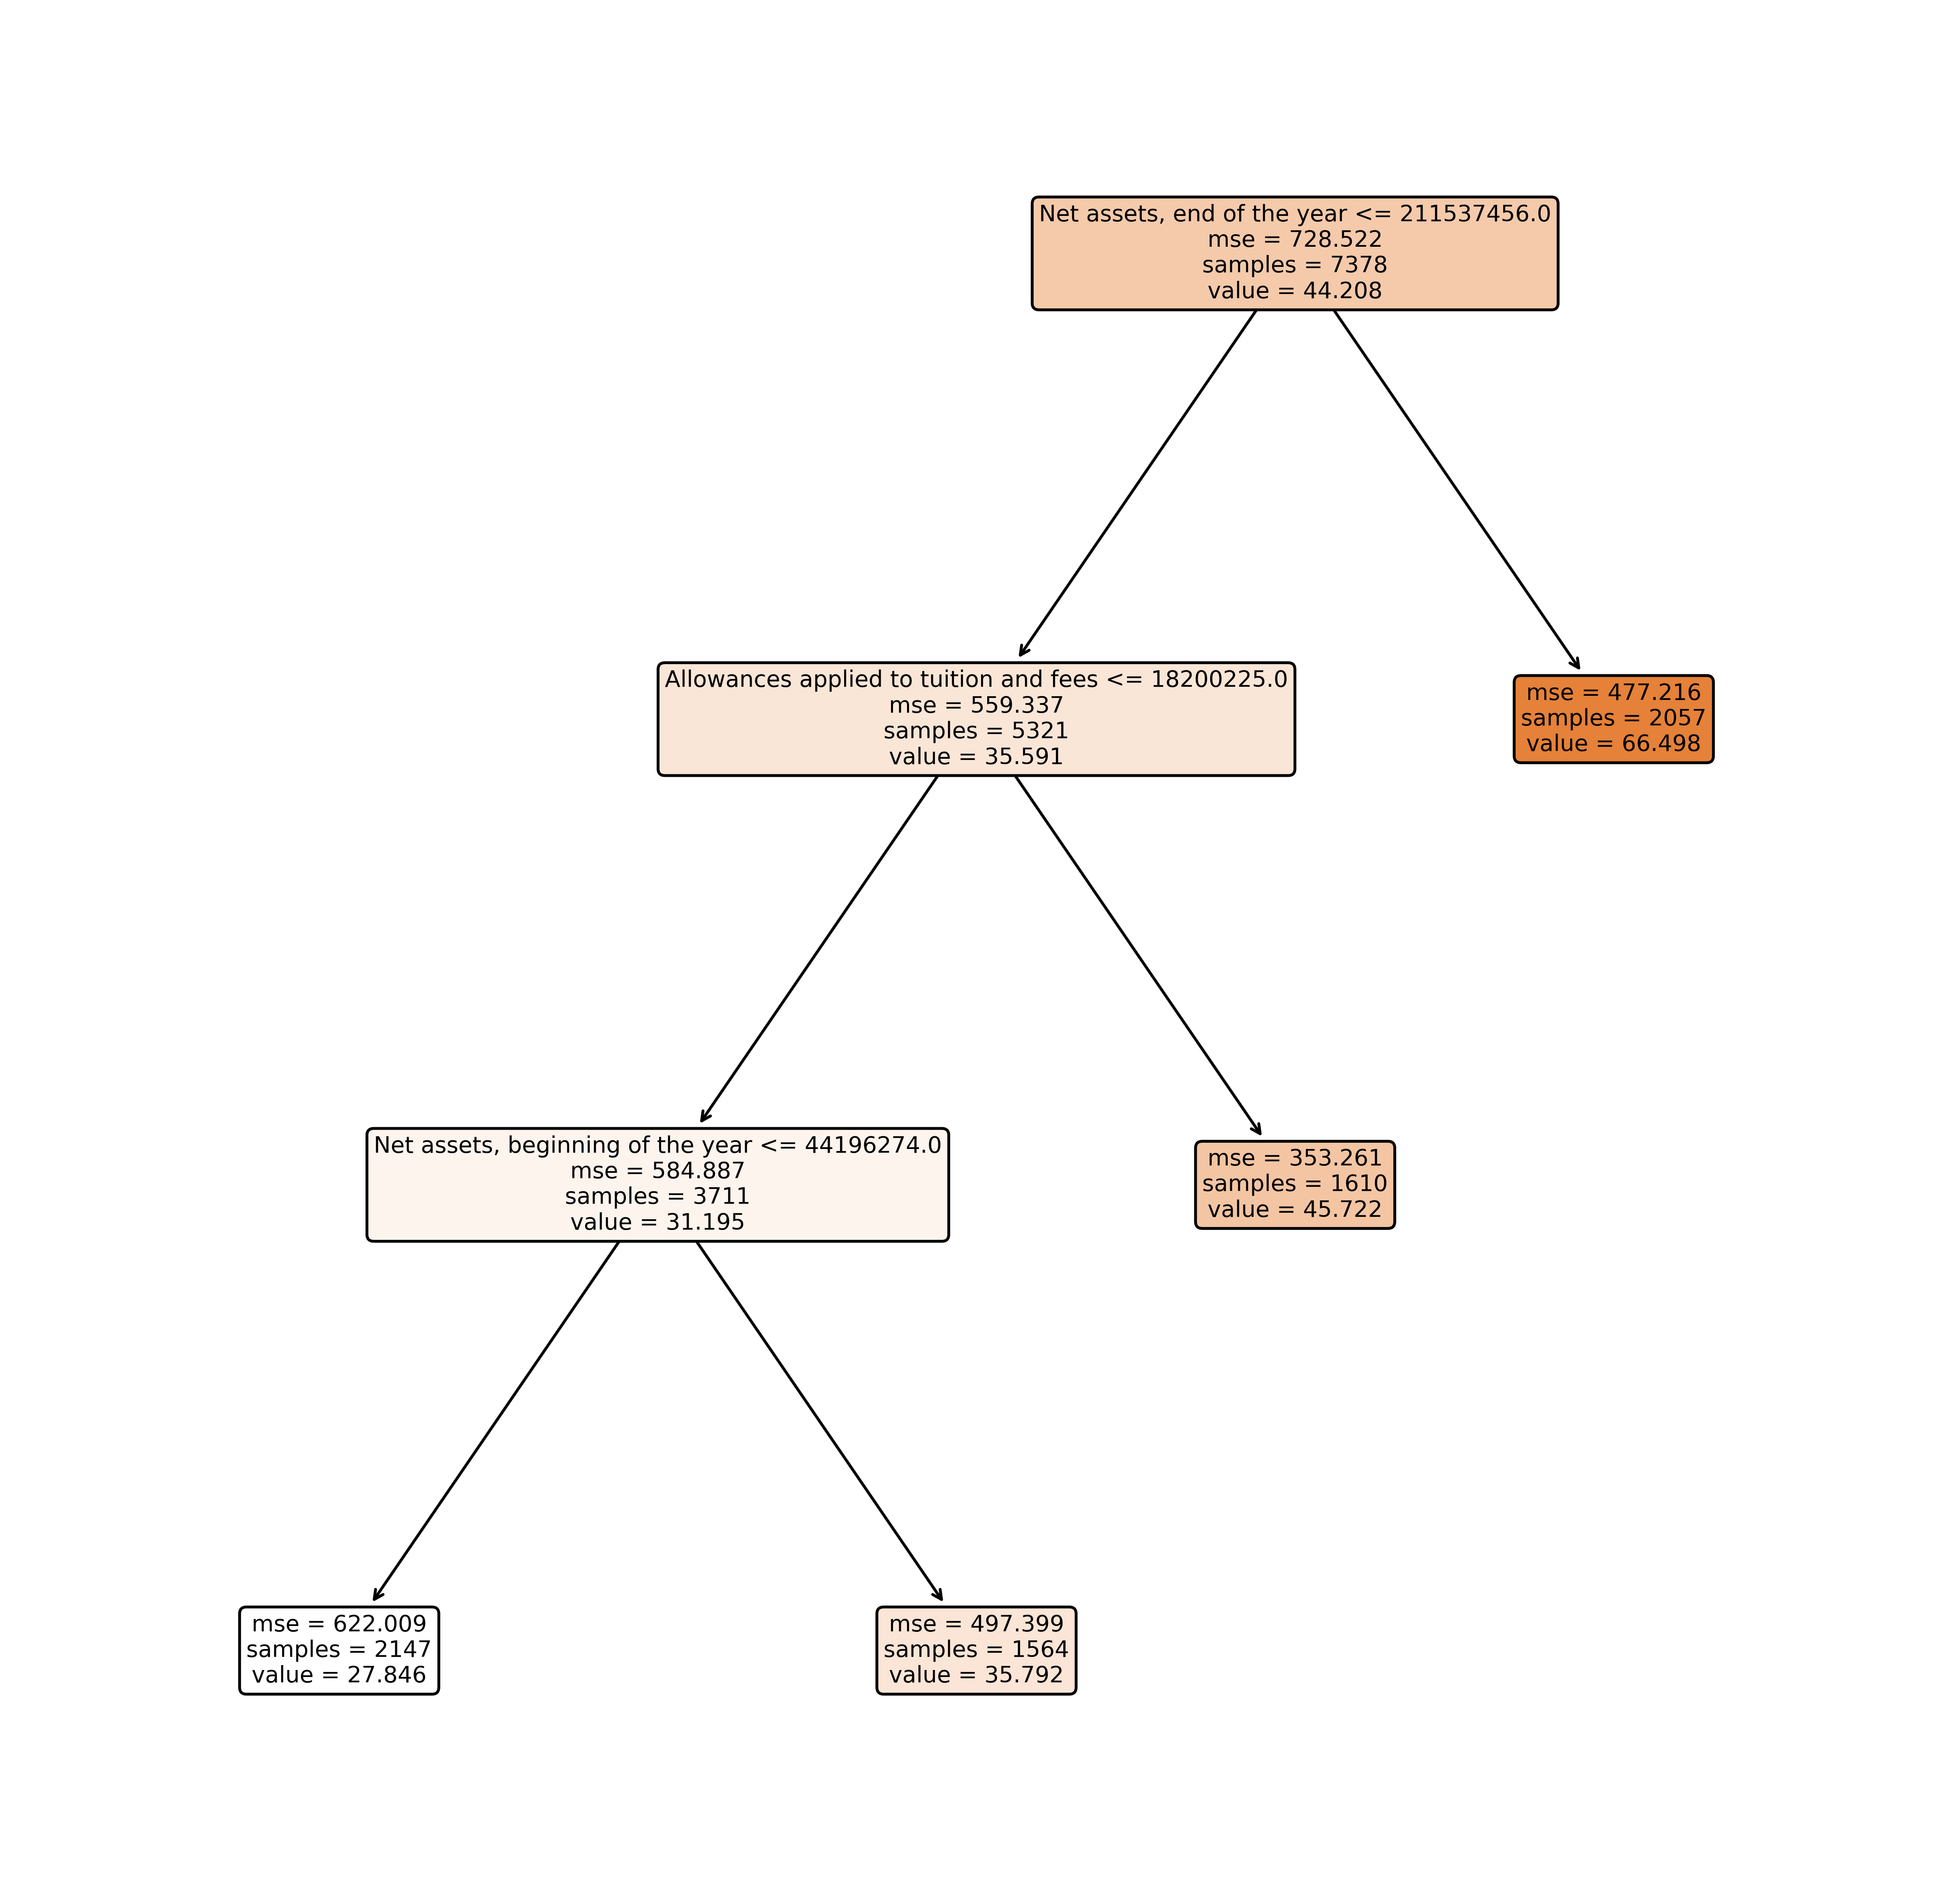

In [124]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
plot_tree(separate_tree_pr, 
               feature_names=X_train_pr_sel.columns,
               class_names=np.unique(y_train_pr).astype('str'),
               filled=True, rounded=True)
plt.show()

In [125]:
si= SimpleImputer()
X_train_pub_imputed= si.fit_transform(X_train_pub)
X_train_pub_imputed=pd.DataFrame(X_train_pub_imputed, 
    index=X_train_pub.index, columns=X_train_pub.columns)
#feature Selection
sel_pub= SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6, random_state=42))
sel_pub.fit(X_train_pub_imputed, y_train_pub)
selected_feat_pub= X_train_pub_imputed.columns[(sel_pub.get_support())]
selected_feat_pub = selected_feat_pub.tolist()
X_train_pub_sel=X_train_pub_imputed[selected_feat_pub]

In [126]:
separate_tree_pub= DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=14,random_state=42)

separate_tree_pub.fit(X_train_pub_sel, y_train_pub)
separate_tree_pub_preds =separate_tree_pub.predict(X_train_pub_sel)

separate_tree_pub_score= separate_tree_pub.score(X_train_pub_sel, y_train_pub)
print("Tree PUB R^2:" + str(separate_tree_pub_score))

separate_tree_pub_v = np.mean(cross_val_score(separate_tree_pub, X_train_pub_sel, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(separate_tree_pub_v))

separate_tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,separate_tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(separate_tree_pub_rmse))

Tree PUB R^2:0.4105352114983639
Tree PUB R^2 Validation Score:0.3780604707591819
Tree PUB Root Mean Squared Error:15.877318401585056


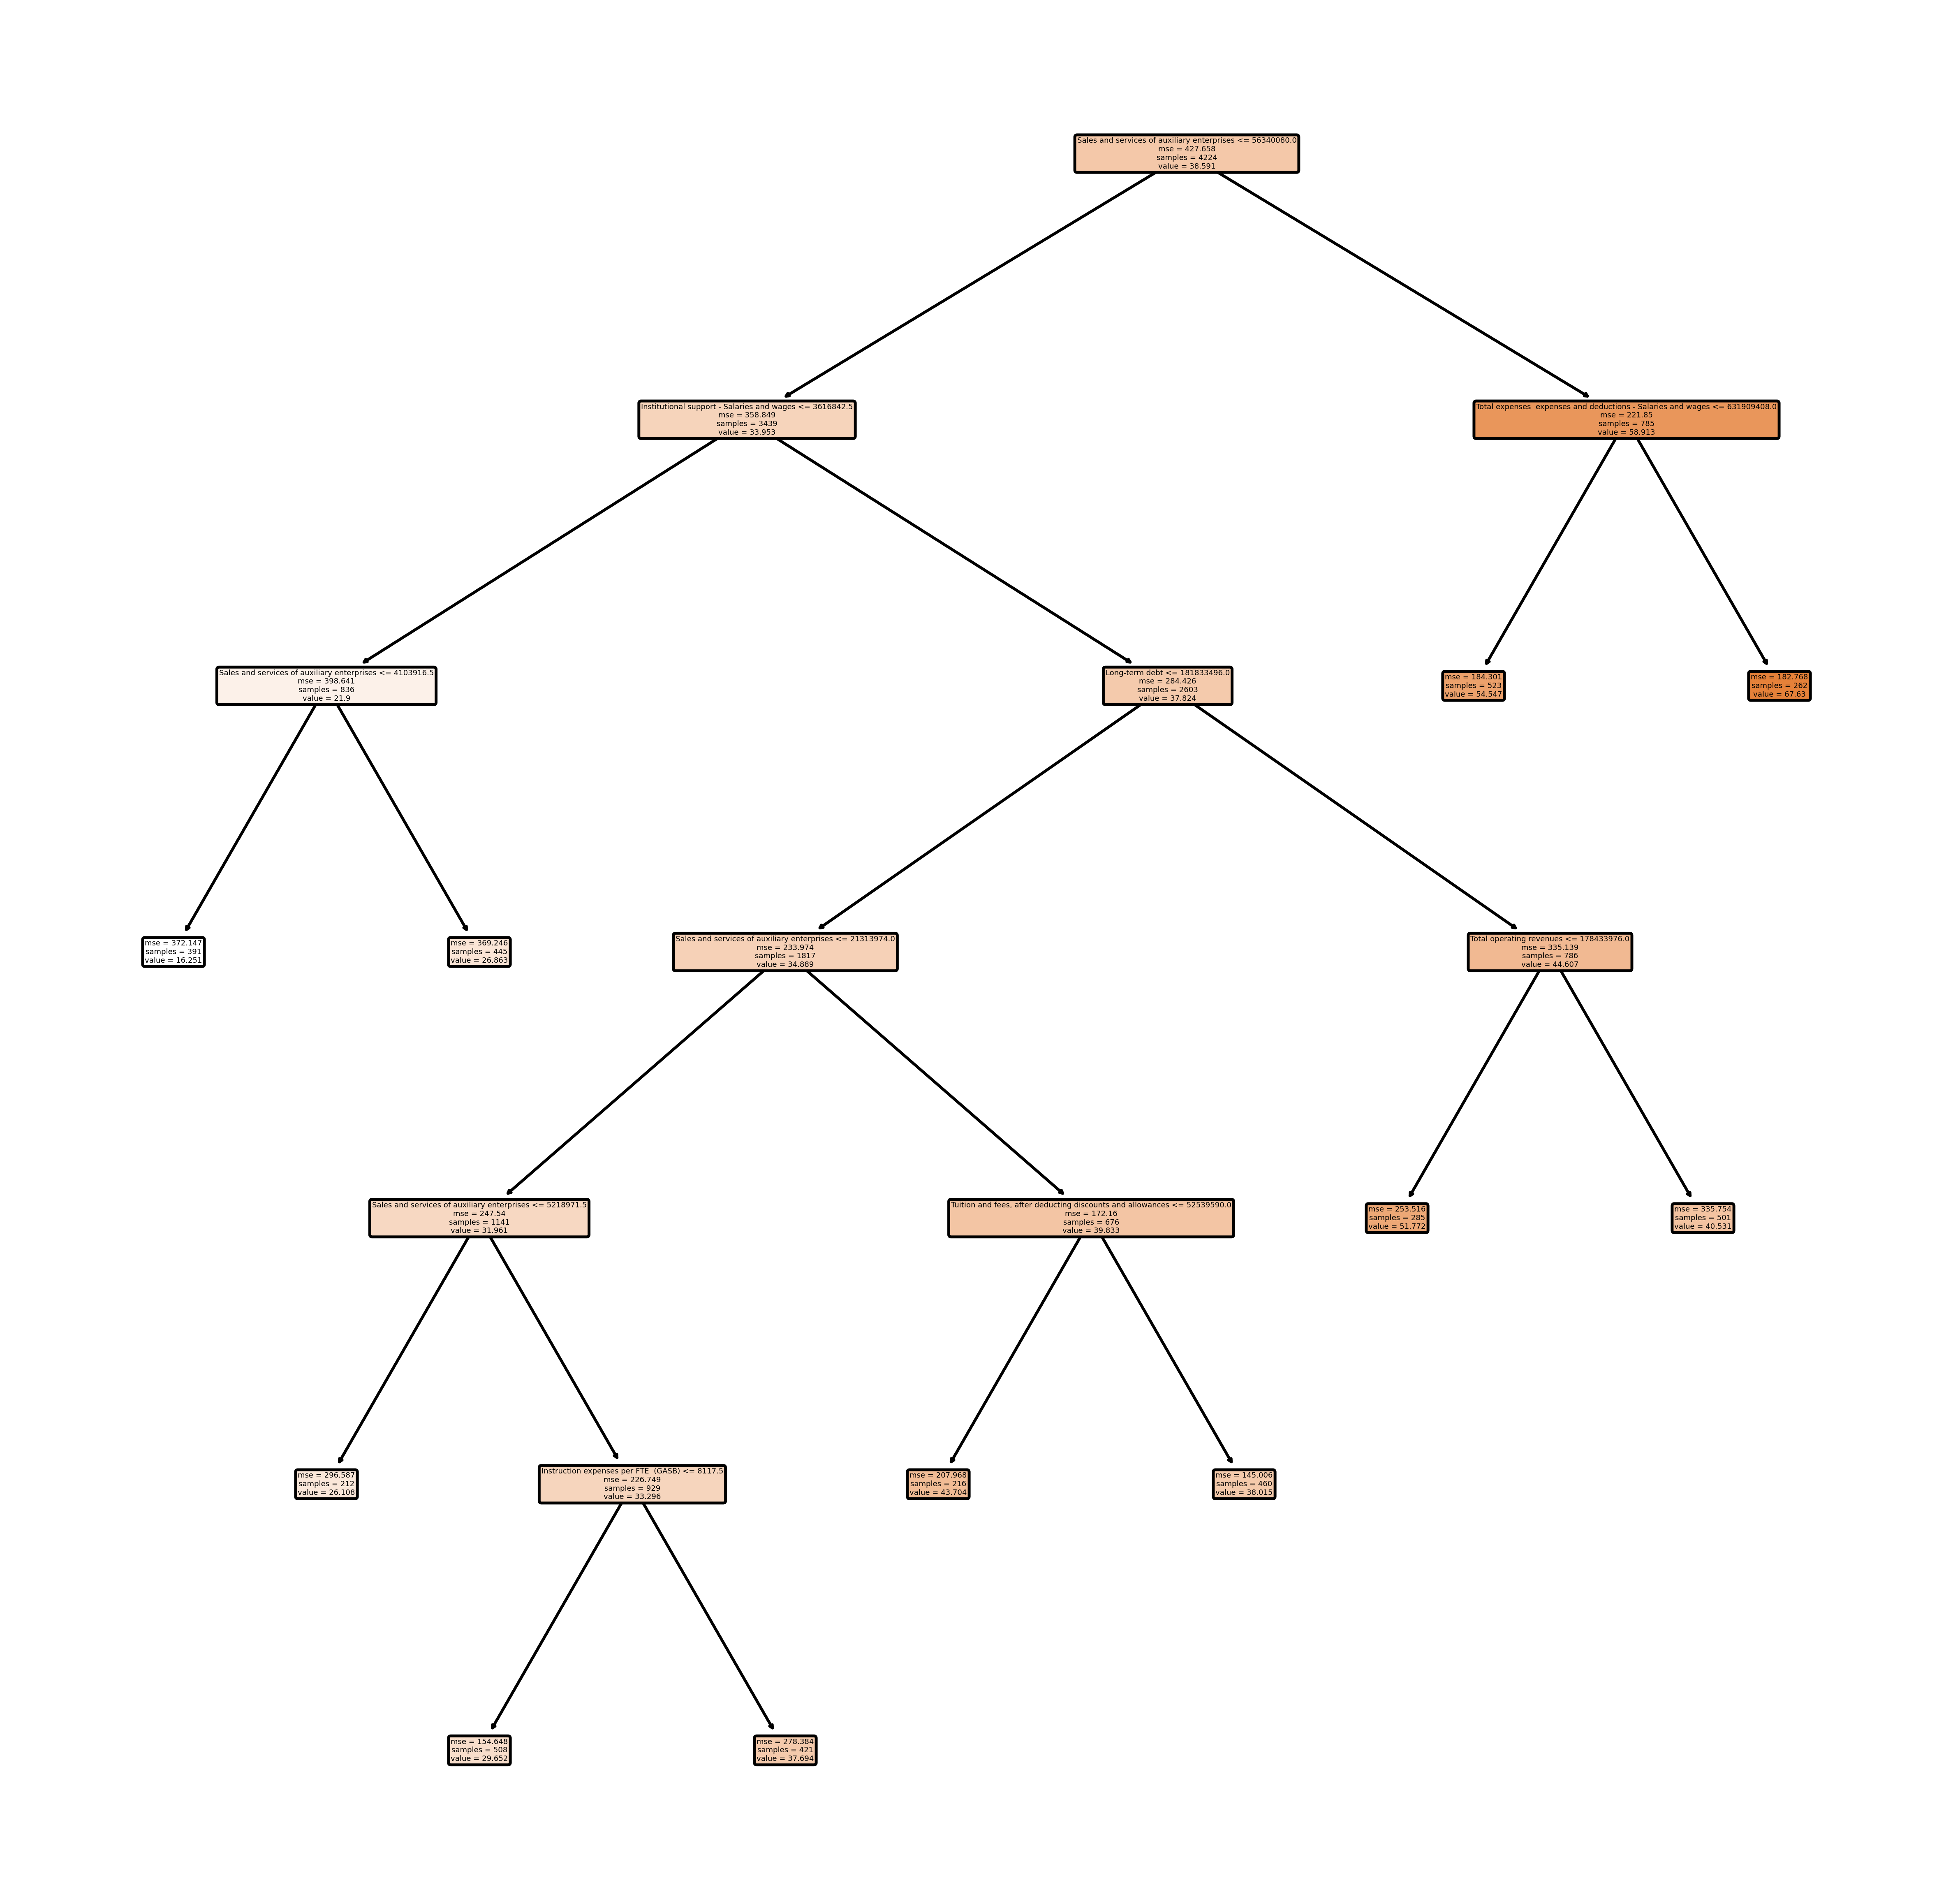

In [127]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
plot_tree(separate_tree_pub, 
               feature_names=X_train_pub_sel.columns,
               class_names=np.unique(y_train_pub).astype('str'),
               filled=True, rounded=True)
plt.show()

## KNN Regression

In [128]:
neigh_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('neigh', KNeighborsRegressor(n_neighbors=2))
])
neigh_pr.fit(X_train_pr, y_train_pr)
neigh_pr_preds=neigh_pr.predict(X_train_pr)
neigh_pr_score= neigh_pr.score(X_train_pr, y_train_pr)
print("KNN PR R^2:" + str(neigh_pr_score))
neigh_pr_v = np.mean(cross_val_score(neigh_pr, X_train_pr, y_train_pr, cv=5))
print("KNN PR R^2 Validation Score:" + str(neigh_pr_v))
neigh_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,neigh_pr_preds))
print('KNN PR Root Mean Squared Error:'+ str(neigh_pr_rmse))

KNN PR R^2:0.7802602112940732
KNN PR R^2 Validation Score:0.31276968191014254
KNN PR Root Mean Squared Error:12.65247745254573


In [129]:
neigh_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('neigh', KNeighborsRegressor(n_neighbors=2))
])
neigh_pub.fit(X_train_pub, y_train_pub)
neigh_pub_preds=neigh_pub.predict(X_train_pub)
neigh_pub_score= neigh_pub.score(X_train_pub, y_train_pub)
print("KNN PUB R^2:" + str(neigh_pub_score))
neigh_pub_v = np.mean(cross_val_score(neigh_pub, X_train_pub, y_train_pub, cv=5))
print("KNN PUB R^2 Validation Score:" + str(neigh_pub_v))
neigh_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,neigh_pub_preds))
print('KNN PUB Root Mean Squared Error:'+ str(neigh_pub_rmse))

KNN PUB R^2:0.836419326788286
KNN PUB R^2 Validation Score:0.48687999340017785
KNN PUB Root Mean Squared Error:8.364003692320534


## XGBoost

In [130]:
XGB_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('xgb', XGBRegressor(random_state=42, learning_rate=.1, max_depth=6, min_child_weight=2,
    n_estimators=100, subsample=.7))
])
XGB_pr.fit(X_train_pr, y_train_pr)
XGB_pr_preds=XGB_pr.predict(X_train_pr)
XGB_pr_score= XGB_pr.score(X_train_pr, y_train_pr)
print("XGB PR R^2:" + str(XGB_pr_score))
XGB_pr_v = np.mean(cross_val_score(XGB_pr, X_train_pr, y_train_pr, cv=5))
print("XGB PR R^2 Validation Score:" + str(XGB_pr_v))
XGB_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,XGB_pr_preds))
print('XGB PR Root Mean Squared Error:' + str(XGB_pr_rmse))

XGB PR R^2:0.8036059656239407
XGB PR R^2 Validation Score:0.472985538182572
XGB PR Root Mean Squared Error:11.96149234192082


In [131]:
XGB_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('xgb', XGBRegressor(learning_rate=.1, max_depth=6, min_child_weight=1, 
    subsample=.7, n_estimators=100, random_state=42))
])
XGB_pub.fit(X_train_pub, y_train_pub)
XGB_pub_preds=XGB_pub.predict(X_train_pub)
XGB_pub_score= XGB_pub.score(X_train_pub, y_train_pub)
print("XBG PUB R^2:" + str(XGB_pub_score))
XGB_pub_v = np.mean(cross_val_score(XGB_pub, X_train_pub, y_train_pub, cv=5))
print("XGB PUB R^2 Validation Score:" + str(XGB_pub_v))
XGB_pr_rmse = np.sqrt(mean_squared_error(y_train_pub,XGB_pub_preds))
print('XGB PUB Root Mean Squared Error:' + str(XGB_pr_rmse))

XBG PUB R^2:0.8886172744452246
XGB PUB R^2 Validation Score:0.6060516839486143
XGB PUB Root Mean Squared Error:6.901716894521904
